In [1]:
import numpy as np
import pytest
import numpy.typing as npt
import matplotlib as plt


In [2]:
class NormalFormGameCalculator:

    # non zero sum game constructor
    def __init__(self,
                 row_player_utility_matrix: npt.NDArray[np.float64],
                 column_player_utility_matrix: npt.NDArray[np.float64]) -> None:

        self.row_player_utility_matrix = row_player_utility_matrix
        self.column_player_utility_matrix = column_player_utility_matrix

        # if col player utility is not provided, we consider this a zero sum game
        if(column_player_utility_matrix is None):
            self.column_player_utility_matrix = -row_player_utility_matrix


    # calculation section

    def calculate_utilities(self,
                            row_player_strategy: npt.NDArray[np.float64],
                            column_player_strategy: npt.NDArray[np.float64]) -> [np.float64, np.float64]:


        action_probabilities = row_player_strategy @ column_player_strategy
        assert action_probabilities.sum() == pytest.approx(1)

        row_player_utility = action_probabilities * self.row_player_utility_matrix
        column_player_utility = action_probabilities * self.column_player_utility_matrix

        return row_player_utility.sum(), column_player_utility.sum()

    def get_best_response_strategy_against_row_player(self,
                                                  row_player_strategy: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        assert row_player_strategy.sum() == pytest.approx(1)
        length = self.column_player_utility_matrix.shape[1]
        array_of_zeros = np.zeros(length)
        utilities =  self.column_player_utility_matrix.T @ row_player_strategy
        index = np.argmax(utilities, axis=0)
        array_of_zeros[index] = 1
        reshaped = np.reshape(array_of_zeros, (1, length))
        return (reshaped)
    
    def get_best_response_strategy_against_column_player(self,
                                                  column_player_strategy: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        
        assert column_player_strategy.sum() == pytest.approx(1)
        length = self.row_player_utility_matrix.shape[0]
        array_of_zeros = np.zeros(length)
        utilities = column_player_strategy @ self.row_player_utility_matrix.T
        index = np.argmax(utilities, axis=1)
        array_of_zeros[index] = 1

        reshaped = np.reshape(array_of_zeros, (length, 1))
        return (reshaped)

    # jak moc si hrac prilepsi kdyz switchne na best response
    def incentive_to_deviate(self,
                             row_player_strategy: npt.NDArray[np.float64],
                            column_player_strategy: npt.NDArray[np.float64]) -> [np.float64, np.float64]:
        
        row_utility, column_utility = self.calculate_utilities(row_player_strategy, column_player_strategy)

        best_row = self.get_best_response_strategy_against_column_player(column_player_strategy)
        best_column = self.get_best_response_strategy_against_row_player(row_player_strategy)

        _, best_column_utility = self.calculate_utilities(row_player_strategy, best_column)
        best_row_utility, _ = self.calculate_utilities(best_row, column_player_strategy)

        return (best_column_utility - column_utility, best_row_utility - row_utility)

    def nash_conv(self, incentives_to_deviate : npt.NDArray[np.float64]) -> np.float64:
        return incentives_to_deviate.sum()

    def get_exploitability(self, nash_conv: np.float64, num_of_players: np.int32) -> np.float64:
        return nash_conv / num_of_players

    def get_epsilon_for_minimum_nash_equilibrium(self, incentives_to_deviate : npt.NDArray[np.float64]) -> np.float64:
        return incentives_to_deviate.max()


In [3]:
"""
ROW_rock_paper_scissors__utility_matrix = np.array([[1, 1, 1],
                                                    [0, 0, 0]])

COLUMN_rock_paper_scissors__utility_matrix = np.array([[1, 0, 0],
                                                       [0, 100, 0]])

row_strategy = np.array([[0.9,
                          0.1]]).transpose()


column_strategy = np.array([[1/3, 1/3, 1/3]])

game = NormalFormGameCalculator(ROW_rock_paper_scissors__utility_matrix, COLUMN_rock_paper_scissors__utility_matrix)

best_col = game.get_best_response_strategy_against_row_player(row_strategy)

best_col
"""


'\nROW_rock_paper_scissors__utility_matrix = np.array([[1, 1, 1],\n                                                    [0, 0, 0]])\n\nCOLUMN_rock_paper_scissors__utility_matrix = np.array([[1, 0, 0],\n                                                       [0, 100, 0]])\n\nrow_strategy = np.array([[0.9,\n                          0.1]]).transpose()\n\n\ncolumn_strategy = np.array([[1/3, 1/3, 1/3]])\n\ngame = NormalFormGameCalculator(ROW_rock_paper_scissors__utility_matrix, COLUMN_rock_paper_scissors__utility_matrix)\n\nbest_col = game.get_best_response_strategy_against_row_player(row_strategy)\n\nbest_col\n'

In [4]:
ROW_rock_paper_scissors__utility_matrix = np.array([[0, 1, -1], [-1, 0, 1], [1, -1, 0]])

COLUMN_rock_paper_scissors__utility_matrix = np.array([[0, -1, 1], [1, 0, -1], [-1, 1, 0]])

row_strategy = np.array([[0.1,
                          0.2,
                          0.7]]).transpose()

column_strategy = np.array([[0.3, 0.2, 0.5]])


normal_game_calculator = NormalFormGameCalculator(ROW_rock_paper_scissors__utility_matrix, COLUMN_rock_paper_scissors__utility_matrix)

row_util, _ = normal_game_calculator.calculate_utilities(row_strategy, column_strategy)

assert row_util == pytest.approx(0.08)

row_util

0.08000000000000002

In [5]:


best_col = normal_game_calculator.get_best_response_strategy_against_row_player(row_strategy)
best_row = normal_game_calculator.get_best_response_strategy_against_column_player(column_strategy)


# values when facing best responding opponent
rowvalue2, _ = normal_game_calculator.calculate_utilities(row_strategy, best_col)
_, colvalue1 = normal_game_calculator.calculate_utilities(best_row, column_strategy)


assert rowvalue2 == pytest.approx(-0.6)
assert colvalue1 == pytest.approx(-0.2)


rowvalue2, colvalue1

(-0.6, -0.2)

In [6]:

def get_dominated_action_per_axis(matrix, axis):
    dominated_actions = []
    for i in range(matrix.shape[axis]):
        for j in range(matrix.shape[axis]):
            if i >= j:
                continue
            if np.all(np.take(matrix, i, axis=axis) >= np.take(matrix, j, axis=axis)):
                dominated_actions.append(j)
    return dominated_actions

def get_dominated_actions(matrix1, matrix2):
    dominated_rows = get_dominated_action_per_axis(matrix1, axis=0)
    dominated_columns = get_dominated_action_per_axis(matrix2, axis=1)
    return dominated_rows, dominated_columns

def iterated_removal_of_dominated_strategies(row_utility_matrix, column_utility_matrix):
    temp_row_utility = row_utility_matrix
    temp_column_utility = column_utility_matrix
    while True:
        dominated_rows, dominated_columns = get_dominated_actions(temp_row_utility, temp_column_utility)
        if len(dominated_rows) + len(dominated_columns) == 0:
            break
    
        non_dominated_mask = np.ones(temp_row_utility.shape[0], dtype=bool)
        non_dominated_mask[dominated_rows] = 0
        
        temp_row_utility = temp_row_utility[non_dominated_mask]
        temp_column_utility = temp_column_utility[non_dominated_mask]

        non_dominated_mask = np.ones(temp_row_utility.shape[1], dtype=bool)
        non_dominated_mask[dominated_columns] = 0

        temp_row_utility = temp_row_utility[:,non_dominated_mask]
        temp_column_utility = temp_column_utility[:,non_dominated_mask]

    return temp_row_utility, temp_column_utility

matrix1 = np.array([[11,1,7], [4,3,6], [-1,2,8]])
matrix2 = np.array([[3,4,3], [1,3,2], [9,8,-1]])

matrixA, matrixB = iterated_removal_of_dominated_strategies(row_utility_matrix=matrix1, column_utility_matrix=matrix2)
expected_matrixA = np.array([[11, 1], [4, 3]])
expected_matrixB = np.array([[3, 4], [1, 3]])

assert np.array_equal(matrixA, expected_matrixA)
assert np.array_equal(matrixB, expected_matrixB)

matrix1 = np.array([[10,5,3], [0,4,6], [2,3,2]])
matrix2 = np.array([[4,3,2], [1,6,0], [1,5,8]])

matrixA, matrixB = iterated_removal_of_dominated_strategies(row_utility_matrix=matrix1, column_utility_matrix=matrix2)
expected_matrixA = np.array([[10]])
expected_matrixB = np.array([[4]])

assert np.array_equal(matrixA, expected_matrixA)
assert np.array_equal(matrixB, expected_matrixB)

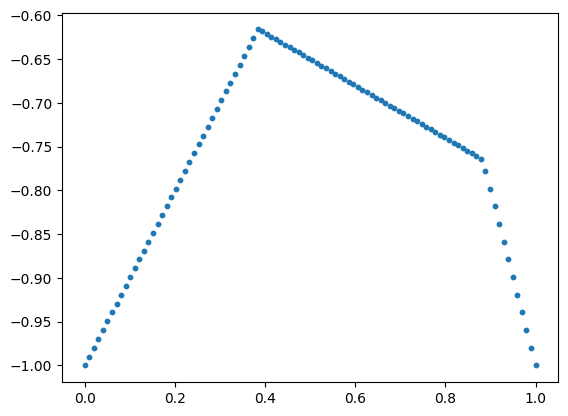

In [7]:
import matplotlib as plt
from typing import List, Optional
import scipy
import matplotlib.pyplot as plt

# vykreslim graf value kdyz hraju proti BR tak jak dopadnu, postupne zkousim "vsechny" strategie

matrix = np.array([[-1, 0, -0.8],
                [1, -1, -0.5]])

normal_game_calculator = NormalFormGameCalculator(matrix, None)

step_size=0.01

steps = np.linspace(0, 1, int(1 / step_size))


def draw_value_function():
    vals = []
    for step in steps:
        row_strat = np.array([[step, 1-step]]).transpose()
        column_best = normal_game_calculator.get_best_response_strategy_against_row_player(row_strat)

        row_util, col_util = normal_game_calculator.calculate_utilities(row_strat, column_best)
        vals.append(row_util)
    return vals

vals = draw_value_function()

plt.scatter(steps, vals, s=10)
plt.show()



In [8]:

def verify_support_one_side(matrix: np.array, support_row: List, support_col: List) -> Optional[List]:
    submatrix = matrix[support_row][:, support_col]
    print(f"submatrix {submatrix}")
    # print(f"submatrix.T {submatrix.T}")
    result = verify_matrix(submatrix)
    if result.success:
        return result.x[1:]
    return None
    num_rows, num_cols = submatrix.shape
    # print(f"rows: {num_rows}, cols: {num_cols}")



    # 1*-U_1 1*p_1 0*p_2 = 0
    # 1*-U_2 2*p_1 1*p_2 = 0
    # 0 1*p_1 1*p_2 = 1


    # print(f"submatrix: \n{submatrix}")
    # print(f"submatrix.T: \n{submatrix.T}")
    # add utility
    A_eq = np.hstack([np.array([[1]*num_rows]).T, submatrix])
    print(A_eq)
    # print(f"with utility: \n{A_eq}")

    # probabilites sum to 1
    A_eq = np.vstack([A_eq, [0]+[1]*(num_cols)])
    # total utility + sum of prob[i] * utility[i] = 0, sum of prob[i] = 1
    b_eq = [0] * (num_rows) + [1]
    # max utility
    c = [1] + [0] * num_cols

    # bounds for utility and probabilities
    bounds = [(None, None)] + [(0,1) for _ in range(num_cols)]



    # print(f"A_eq: {A_eq.shape}")
    # print(f"b_eq: {len(b_eq)}")
    # print(f"c: {len(c)}")
    # print(f"submatrix: \n{A_eq}")
    # print(f"b: {b_eq}")
    # print(f"c: {c}")
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
    # result = linprog(c, A_ub=A_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)

    if result.success:
        # if np.all(result.x[1:] > 0):
        return result.x[1:]
            # print("more than 0")
        # print(f"utility: {result.x[0]}")


        return None

    # print(matrix)
    # print(submatrix)
    # print(support_row)
    # print(support_col)
    return None

def verify_matrix(submatrix: np.array):
    num_rows, num_cols = submatrix.shape
    A_eq = np.hstack([np.array([[1]*num_rows]).T, submatrix])
    A_eq = np.vstack([A_eq, [0]+[1]*(num_cols)])
    print(A_eq)
    print('--')
    b_eq = [0] * (num_rows) + [1]
    print(b_eq)
    print('--')
    c = [1] + [0] * num_cols
    print(c)
    bounds = [(None, None)] + [(0,1) for _ in range(num_cols)]

    return scipy.optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)


def get_all_possible_supports(n_actions: int, m_actions: int):
    actions1 = list(range(n_actions))
    actions2 = list(range(m_actions))
    subset_pairs = []
    for i in range(1,1 << len(actions1)):
        subset1 = [actions1[j] for j in range(len(actions1)) if (i & (1 << j)) > 0]

        for j in range(1,1 << len(actions2)):
            subset2 = [actions2[k] for k in range(len(actions2)) if (j & (1 << k)) > 0]

            subset_pairs.append((subset1, subset2))
    return subset_pairs


def nash_equlibrium_for_supports(matrix: np.array):
    n, m = matrix.shape
    all_supports = get_all_possible_supports(n, m)
    results = {}
    i = 1
    for row, col in all_supports:
        # print(f"{i}/{len(all_supports)}")
        i += 1
        res = verify_support_one_side(matrix=matrix, support_row=row, support_col=col)
        if res is not None and len(row) > 1 and len(col) > 1:
            results[f"row: {row}, col: {col}"] = res

    return results



matrix_p1 = np.array([[0, 0, -10],
                      [1, -10, -10],
                      [-10, -10, -10]])

matrix_p2 = np.array([[0, 1, -10],
                      [0, -10, -10],
                      [-10, -10, -10]])



result = verify_support_one_side(matrix = matrix_p1, support_row=[0, 1], support_col = [0, 1, 2])
print(f"result: {result}")
print('------------')
result = verify_support_one_side(matrix = matrix_p1, support_row=[0, 1, 2], support_col = [0, 1])
print(f"result: {result}")

# enumerate_all_supports(matrix)
# matrix = np.array([[0, 1, -1], [-1, 0, 1], [1, -1, 0]])
# results = nash_equlibrium_for_supports(matrix)

# for strat, res in results.items():
#     print(strat, "prob:", res)


# matrix_p1 = np.array([[0, 0, -10], [1, -10, -10], [-10, -10, -10]])
# results = nash_equlibrium_for_supports(matrix_p1)
# for strat, res in results.items():
#     print(strat, "prob:", res)

submatrix [[  0   0 -10]
 [  1 -10 -10]]
[[  1   0   0 -10]
 [  1   1 -10 -10]
 [  0   1   1   1]]
--
[0, 0, 1]
--
[1, 0, 0, 0]
result: [0.90909091 0.09090909 0.        ]
------------
submatrix [[  0   0]
 [  1 -10]
 [-10 -10]]
[[  1   0   0]
 [  1   1 -10]
 [  1 -10 -10]
 [  0   1   1]]
--
[0, 0, 0, 1]
--
[1, 0, 0]
result: None


In [9]:
ROW_rock_paper_scissors__utility_matrix = np.array([[0, 1, -1], [-1, 0, 1], [1, -1, 0]])

COLUMN_rock_paper_scissors__utility_matrix = np.array([[0, -1, 1], [1, 0, -1], [-1, 1, 0]])

row_strategy = np.array([[1/3,
                          1/3,
                          1/3]]).transpose()

column_strategy = np.array([[1/3, 1/3, 1/3]])


# week 3 hw
normal_game_calculator = NormalFormGameCalculator(ROW_rock_paper_scissors__utility_matrix, None)

row_dev, col_dev = normal_game_calculator.incentive_to_deviate(row_strategy, column_strategy)

# kdyz mame strategy profile ktery tvori nash equilibrium tak neni duvod menit strategii
assert row_dev == pytest.approx(0)
assert col_dev == pytest.approx(0)


In [10]:
row_strategy = np.array([[0.1,
                          0.1,
                          0.8]]).transpose()

column_strategy = np.array([[0.8, 0.1, 0.1]])

normal_game_calculator = NormalFormGameCalculator(ROW_rock_paper_scissors__utility_matrix, None)

row_dev, col_dev = normal_game_calculator.incentive_to_deviate(row_strategy, column_strategy)

nashconv = normal_game_calculator.nash_conv(np.array([row_dev, col_dev]))

exploitability = normal_game_calculator.get_exploitability(nashconv, num_of_players = 2)

epsilon = normal_game_calculator.get_epsilon_for_minimum_nash_equilibrium(np.array([row_dev, col_dev]))

row_dev, col_dev, nashconv, epsilon

(1.1900000000000002,
 0.21000000000000002,
 1.4000000000000001,
 1.1900000000000002)

In [11]:
# self play stuff

matrix = np.array([[-1, 0, -0.8],
                [1, -1, -0.5]])

row_strategy = np.array([[0.1,
                          0.9]]).transpose()

column_strategy = np.array([[0.8, 0.1, 0.1]])



class NormalFormGameSelfPlay:
    def __init__(self, calculator: NormalFormGameCalculator) -> None:
        self.calculator = calculator

    def play(self, number_of_iterations: int = 20) -> None:
        pass


normal_game_calculator = NormalFormGameCalculator(matrix, None)
#self_play = NormalFormGameSelfPlay(normal_game_calculator)
#self_play.play()






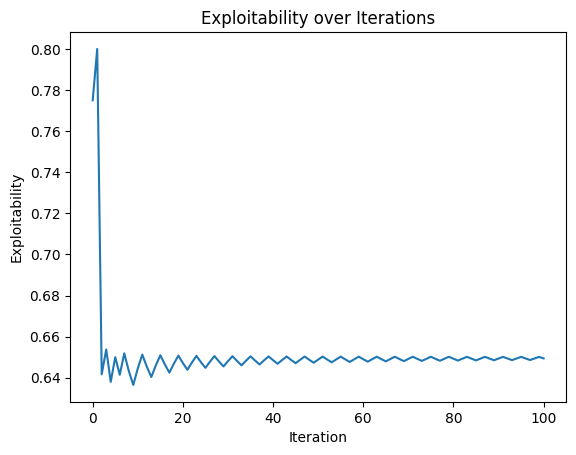

In [12]:
row_player_actions = []
col_player_actions = []

exploitability = []

average_row_strategy = []

row_dev, col_dev = normal_game_calculator.incentive_to_deviate(row_strategy, column_strategy)
nashconv = normal_game_calculator.nash_conv(np.array([row_dev, col_dev]))
row_exploitability = normal_game_calculator.get_exploitability(nashconv, num_of_players = 2)

exploitability.append(row_exploitability)

row_player_actions.append(row_strategy)
col_player_actions.append(column_strategy)

for i in range(100):

    col_strat = col_player_actions[-1]
    row_strat = row_player_actions[-1]

    best_row_strat = normal_game_calculator.get_best_response_strategy_against_column_player(col_strat)
    best_col_strat = normal_game_calculator.get_best_response_strategy_against_row_player(row_strat)

    row_player_actions.append(best_row_strat)
    col_player_actions.append(best_col_strat)

    row_dev, col_dev = normal_game_calculator.incentive_to_deviate(np.mean(row_player_actions, axis=0), column_strategy)
    nashconv = normal_game_calculator.nash_conv(np.array([row_dev, col_dev]))
    row_exploitability = normal_game_calculator.get_exploitability(nashconv, num_of_players = 2)
    exploitability.append(row_exploitability)

exploitability

plt.plot(exploitability)
plt.xlabel('Iteration')
plt.ylabel('Exploitability')
plt.title('Exploitability over Iterations')
plt.show()
